In [ ]:
"""
Copyright 2023 Gaston Sivori

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

Notebook used to plot Figure 7. Data is not available. Data was obtained running run_net.jl file.

In [1]:
using Plots
using JLD2
using StatsPlots
#plotting parameters
N = 500;
excitatory_n = 400;
tfactor = 1.0;
sim_length = 10000.0 * tfactor;
sim_δt = 0.1;
sim_steps = Int(sim_length/sim_δt);
ticks = 1000.0 * tfactor;
bins = 50;
dpi = 150;
box_width = 250;
box_len = box_width*sim_δt;
Nbins = Int(round(sim_length/sim_δt/box_width,digits=2));
k = zeros(Nbins,N);
pss = zeros(Int(sim_length/sim_δt),N);
t = collect(range(0.0, stop = sim_length, length=Int(100000 * tfactor))) ./ 1000.0;
default(legendfontsize = 12, guidefont = (12, :black), guide="", tickfont = (10, :gray), framestyle = nothing, yminorgrid = true, xminorgrid = true, size=(1800,1200), dpi=150);

#helper functions
include("funs.jl");

In [2]:
seed = 2021
sim_name = "new_10sec_" #change this to appropriate name
filepathname = string("../jlds/",N,"/",sim_name,seed,".jld2");

In [3]:
filepathname

"../jlds/500/new_10sec_2021.jld2"

In [15]:
#to load
@load filepathname spikes ns v_dend v_soma gain_mod w g κ pattern #gcd poisson_in (!)
#(inputs,pattern,pat1,pat2,pat3) = poisson_in
(Pi, Pr, csid) = w;
(ge, gi, gcd) = g;

In [8]:
#timestamps
timestamps = [(pat_time*sim_δt/1000.0,round(pattern[index+1][2]*sim_δt,digits=1)/1000.0) 
                for (index, (_,pat_time)) in enumerate(pattern) if index < length(pattern)];
push!(timestamps,(timestamps[end][2],sim_length));
#network spike times
vals, y = rasters(spikes,ns);
#xs,ys, grouping = groupbypat(vals,y,pattern,sim_δt);
xs,ys, grouping = groupbynat(vals,y,excitatory_n);
#output spike bins
pss = bin_netspikes(spikes,Nbins,box_width,sim_steps,sim_δt);
#for pattern colors
patcl = palette(:default);
cln = maximum(pattern)[1];
patcl = patcl[1:cln];

In [9]:
gr(yminorgrid=false,ytickfont=font(12),xtickfont=font(12),guidefont=font(12),legendfontsize=12,xminorgrid=false,minorgrid=false,
yguidefontsize=12,xguidefontsize=12,left_margin=5Plots.mm,right_margin=5Plots.mm,bottom_margin=3Plots.mm,dpi=150)

Plots.GRBackend()

In [14]:
window = (0.,10.)
gr(markersize=3.,markershape=:vline,legend=false, markercolor=:black, markerstrokewidth=1.0, markeralpha=1.0, linewidth=1.0)
h0 = plot(xlabel="Time (s)", ylabel="Neuron ID",xlim=window,ylim=(0.5,N+0.5),size=(800,600))
vspans(h0, timestamps, pattern, window,0.4)
#for clusters
cls = []
for cl in palette(:Set3_3)
    push!(cls,cl)
end
cls = repeat(cls,20)
for (i,cid) in enumerate(csid)
    hspan!(h0,[cid[1],cid[end]],fillalpha=0.4,color=cls[i],linewidth=0.0,alpha=0.0, label=nothing)
end
scatter!(h0,xs,ys, group=grouping, markercolor=[:black :brown],)
plot!()
savefig("rnet.pdf")

"/Users/gsivori/OIST Dropbox/Gaston Sivori/Documents/PhD-Thesis/Project1/src/rnet.pdf"

Let's analyze tuned clusters

In [7]:
#find tuned clusters
#pattern last presentation
pattimes = []
for k in 1:3
    pat_end = [(i,j) for (i,j) in reverse(pattern) if i==k][1]
    push!(pattimes,pat_end)
end

#cluster activity @ last presentation
cl_act = []
for (whichpat,tpat) in pattimes
    for eachrange in csid
        act = sum(tpat*sim_δt .<= spikes[eachrange,:] .<= (tpat+1000)*sim_δt,dims=2)
        push!(cl_act,(whichpat,eachrange,act,sum(act)))
    end
end
byact = reverse(sortperm([thesum for (whichpat,_,_,thesum) in cl_act]))

cl_pat = []
for eachact in byact
    for k in 1:3
        (whichpat,cl,act,thesum) = cl_act[eachact]
        if whichpat == k
            push!(cl_pat,(cl,whichpat))
            break
        end
    end
    if size(cl_pat)[1] == 3
        break
    end
end

#cluster activity @ presentations
clspk_pres = []
for (cl,whichpat) in cl_pat
    pat = [(i,j) for (i,j) in pattern if i==whichpat]
    nspks_per_pat = []
    for (_,tpat) in pat
        thisact = sum(tpat*sim_δt .<= spikes[cl,:] .<= (tpat+1000)*sim_δt,dims=2)
        push!(nspks_per_pat,sum(thisact))
    end
    push!(clspk_pres,(cl,whichpat,nspks_per_pat))
end

In [8]:
cl_pat

3-element Vector{Any}:
 (62:85, 2)
 (180:201, 1)
 (104:127, 3)

In [18]:
clspk_pres

3-element Vector{Any}:
 (62:85, 2, Any[408, 111, 133, 188, 267, 242, 252, 281, 249, 289, 262, 330, 322])
 (180:201, 1, Any[290, 0, 73, 253, 275, 305, 303, 263, 312, 290, 312, 296])
 (104:127, 3, Any[1, 210, 77, 35, 120, 122])

In [20]:
l = @layout [a{0.75w} grid(4,1)]
hrapid = plot(size=(1200,1000),dpi=600,layout=l,grid=false)
plot!(hrapid[1],xlabel="# of pattern presentation", ylabel="Spike count",size=(800,500),xticks=[1,2,3,4,5,6,7,8,9,10,11,12,13])
for (index,cl) in enumerate(reverse(patcl[1:2]))
    plot!(hrapid[1], clspk_pres[index][3],color=cl,label=string(clspk_pres[index][1]),linewidth=2.,markersize=5.0,markerstrokewidth=2.)
end
plot!(hrapid[1],legend=true,background_color_legend=:transparent,foreground_color_legend=:transparent)
gr(markersize=3.,markershape=:vline,legend=false, markercolor=:black, markerstrokewidth=1.0, markeralpha=1.0, linewidth=1.0)
which_cl = 1
pat_t = [(i,j) for (i,j) in pattern if i==2][2][2] #second red
window = ((pat_t) * 1e-3 * sim_δt,(pat_t+1000) * 1e-3 * sim_δt)
vspan!(hrapid[2],[window[1],window[2]],fillalpha=0.25,color=patcl[2],alpha=0.0,label=nothing,xlim=round.(window,digits=2))
scatter!(hrapid[2],xs,ys,group=grouping,markercolor=:black,ylim=(clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]),
xlabel="",ylabel="*",yticks=[clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]],xlim=[window[1]-0.025,window[2]+0.025],
markersize=3.,markershape=:vline,legend=false, markerstrokewidth=1.0, markeralpha=1.0, linewidth=0.,xticks=round.([window[1],window[2]],digits=2),tickfontsize=12)
pat_t = [(i,j) for (i,j) in pattern if i==2][end][2] #last red
window = ((pat_t) * 1e-3 * sim_δt,(pat_t+1000) * 1e-3 * sim_δt)
vspan!(hrapid[3],[window[1],window[2]],fillalpha=0.25,color=patcl[2],alpha=0.0,label=nothing,xlim=round.(window,digits=2))
scatter!(hrapid[3],xs,ys,group=grouping,markercolor=:black,ylim=(clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]),
xlabel="",ylabel="**",yticks=[clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]],xlim=[window[1]-0.025,window[2]+0.025],
markersize=3.,markershape=:vline,legend=false, markerstrokewidth=1.0, markeralpha=1.0, linewidth=0.,xticks=round.([window[1],window[2]],digits=2),tickfontsize=12)
which_cl = 2
pat_t = [(i,j) for (i,j) in pattern if i==1][3][2] #third blue
window = ((pat_t) * 1e-3 * sim_δt,(pat_t+1000) * 1e-3 * sim_δt)
vspan!(hrapid[4],[window[1],window[2]],fillalpha=0.25,color=patcl[1],alpha=0.0,label=nothing,xlim=round.(window,digits=2))
scatter!(hrapid[4],xs,ys,group=grouping,markercolor=:black,ylim=(clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]),
xlabel="",ylabel="***",yticks=[clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]],xlim=[window[1]-0.025,window[2]+0.025],
markersize=3.,markershape=:vline,legend=false, markerstrokewidth=1.0, markeralpha=1.0, linewidth=0.,xticks=round.([window[1],window[2]],digits=2),tickfontsize=12)
pat_t = [(i,j) for (i,j) in pattern if i==1][end][2] #last blue
window = ((pat_t) * 1e-3 * sim_δt,(pat_t+1000) * 1e-3 * sim_δt)
vspan!(hrapid[5],[window[1],window[2]],fillalpha=0.25,color=patcl[1],alpha=0.0,label=nothing,xlim=round.(window,digits=2))
scatter!(hrapid[5],xs,ys,group=grouping,markercolor=:black,ylim=(clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]),
xlabel="Time (s)",ylabel="****",yticks=[clspk_pres[which_cl][1][1],clspk_pres[which_cl][1][end]],xlim=[window[1]-0.025,window[2]+0.025],
markersize=3.,markershape=:vline,legend=false, markerstrokewidth=1.0, markeralpha=1.0, linewidth=0.,xticks=round.([window[1],window[2]],digits=2),fontsize=10)
for eachanot in [(2,118,text("*",16)),(13,328,text("**",16)),(3,84,text("***",16)),(12,304,text("****",16))]
    annotate!(hrapid[1],[(eachanot[1],eachanot[2],eachanot[3])])
end
plot!()
savefig("spkcnt_patpres.png")

"/Users/gsivori/OIST Dropbox/Gaston Sivori/Documents/PhD-Thesis/Project1/src/spkcnt_patpres.png"

Pretty good stuff!!!

In [23]:
n_assemblies = 6
#or
act_threshold = 1.0

1.0

In [24]:
#network results
net_clspk_pres = []
for pseed in ["03","04","05","06","07","08","09",10,11,12,13,14,15,16,17,18,19,20,21,22,23] 
    sim_name = "new_10sec_20"; #change this to appropriate name
    filepathname = string("../jlds/",N,"/",sim_name,pseed,".jld2");
    #to load
    @load filepathname spikes pattern w κ#ns v_dend v_soma gain_mod w g κ pattern #gcd poisson_in (!)
    #(inputs,pattern,pat1,pat2,pat3) = poisson_in
    (Pi, _, csid) = w;
    #(ge, gi, gcd) = g 

    #find tuned clusters
    #pattern last presentation
    pattimes = []
    for k in 1:3
        pat_end = [(i,j) for (i,j) in reverse(pattern) if i==k][1]
        push!(pattimes,pat_end)
    end

    #cluster activity @ last presentation
    cl_act = []
    for (whichpat,tpat) in pattimes
        for eachrange in csid
            act = sum(tpat*sim_δt .<= spikes[eachrange,:] .<= (tpat+1000)*sim_δt,dims=2)
            push!(cl_act,(whichpat,eachrange,sum(act)/length(eachrange)))
        end
    end
    byact = reverse(sortperm([thesum for (whichpat,_,thesum) in cl_act]));

    cl_pat = []
    for eachact in byact
        if (size(cl_pat)[1] >= n_assemblies) || (cl_act[eachact][3] <= act_threshold)
            break
        end
        for k in 1:3
            (whichpat,cl,thesum) = cl_act[eachact]
            if whichpat == k
                push!(cl_pat,(cl,whichpat))
                break
            end
        end
    end
    
    #cluster activity @ presentations
    clspk_pres = []
    for (cl,whichpat) in cl_pat
        pat = [(i,j) for (i,j) in pattern if i==whichpat]
        nspks_per_pat = []
        for (_,tpat) in pat
            thisact = sum(tpat*sim_δt .<= spikes[cl,:] .<= (tpat+1000)*sim_δt,dims=2)
            push!(nspks_per_pat,sum(thisact))
        end
        push!(clspk_pres,(cl,whichpat,nspks_per_pat))
    end
    push!(net_clspk_pres,clspk_pres)


    kstrongs = []
    for eachnet in eachindex(net_clspk_pres)
        for (eachcl,_,_) in net_clspk_pres[eachnet]
            append!(kstrongs,κ[eachcl])
        end
    end    
end

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /Users/gsivori/.julia/packages/JLD2/VWinU/src/JLD2.jl:300


EOFError: EOFError: read end of file

In [14]:
allspikes = []
for eachpres in eachindex(1:14) #at least
    nspikes = []
    for eachnet in eachindex(net_clspk_pres)
        for (csize,pat,spaikus) in net_clspk_pres[eachnet]
            try 
                push!(nspikes,spaikus[eachpres]/length(csize))
            catch 
                continue 
            end
        end
    end
    push!(allspikes,nspikes)
end

Let's repeat for weak clustered networks

In [15]:
#network results
net_weakclspk_pres = []
for pseed in ["03","04","05","06","07","08","09",10,11,12,13,14,15,16,17,18,19,20,21,22,23] 
    sim_name = "new_10sec_weakcl_20"; #change this to appropriate name
    filepathname = string("../jlds/",N,"/",sim_name,pseed,".jld2");
    #to load
    @load filepathname spikes pattern w κ#ns v_dend v_soma gain_mod w g κ pattern #gcd poisson_in (!)
    #(inputs,pattern,pat1,pat2,pat3) = poisson_in
    (_, _, csid) = w;
    #(ge, gi, gcd) = g 

    #find tuned clusters

    #pattern last presentation
    pattimes = []
    for k in 1:3
        pat_end = [(i,j) for (i,j) in reverse(pattern) if i==k][1]
        push!(pattimes,pat_end)
    end

    #cluster activity @ last presentation
    cl_act = []
    for (whichpat,tpat) in pattimes
        for eachrange in csid
            act = sum(tpat*sim_δt .<= spikes[eachrange,:] .<= (tpat+1000)*sim_δt,dims=2)
            push!(cl_act,(whichpat,eachrange,sum(act)/length(eachrange)))
        end
    end
    byact = reverse(sortperm([thesum for (whichpat,_,thesum) in cl_act]));

    cl_pat = []
    for eachact in byact
        if (size(cl_pat)[1] >= n_assemblies) || (cl_act[eachact][3] <= act_threshold)
            break
        end
        for k in 1:3
            (whichpat,cl,thesum) = cl_act[eachact]
            if whichpat == k
                push!(cl_pat,(cl,whichpat))
                break
            end
        end
    end

    #cluster activity @ presentations
    clspk_pres = []
    for (cl,whichpat) in cl_pat
        pat = [(i,j) for (i,j) in pattern if i==whichpat]
        nspks_per_pat = []
        for (_,tpat) in pat
            thisact = sum(tpat*sim_δt .<= spikes[cl,:] .<= (tpat+1000)*sim_δt,dims=2)
            push!(nspks_per_pat,sum(thisact))
        end
        push!(clspk_pres,(cl,whichpat,nspks_per_pat))
    end
    push!(net_weakclspk_pres,clspk_pres)


    kweaks = []
    for eachnet in eachindex(net_weakclspk_pres)
        for (eachcl,_,_) in net_weakclspk_pres[eachnet]
            append!(kweaks,κ[eachcl])
        end
    end
end

In [16]:
allweakspikes = []
for eachpres in eachindex(1:14) #at least
    nspikes = []
    for eachnet in eachindex(net_weakclspk_pres)
        for (csize,_,spaikus) in net_weakclspk_pres[eachnet]
            try 
                push!(nspikes,spaikus[eachpres]/length(csize))
            catch 
                continue 
            end
        end
    end
    push!(allweakspikes,nspikes)
end

In [17]:
x=[ones(length(x))*ii for (ii,x) in enumerate(allspikes)]
y=[ones(length(y))*ii for (ii,y) in enumerate(allweakspikes)]

14-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0  …  3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
 [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0  …  4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
 [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
 [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0  …  6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
 [7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0  …  7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
 [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0  …  8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
 [9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0  …  9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0]
 [10.0, 10.0, 10.0,

Comparison between strong/weak clusters in tuning across presentations

In [22]:
hrapid = plot(xlabel="# of pattern presentation", ylabel="Spike count / Assembly size",size=(800,500),grid=false,
    xticks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

lastpattern = 14

StatsPlots.boxplot!(hrapid[1],x[1:lastpattern],allspikes[1:lastpattern],label="",color="purple",
    alpha=0.5,markershape=:circle,markercolor="purple",linecolor="purple",linewidth=2.0,outliers=false)
StatsPlots.boxplot!(hrapid[1],y[1:lastpattern],allweakspikes[1:lastpattern],label="",color="gray",
    alpha=0.5,markershape=:circle,markercolor="gray",linecolor="gray",linewidth=2.0,outliers=false)

#StatsPlots.pointplot!()
plot!(hrapid[1],mean.(allspikes[1:lastpattern]),marker=(:vline,:black,stroke(2),5.0),linewidth=3.,linecolor="purple",label="Strong assemblies")
plot!(hrapid[1],mean.(allweakspikes[1:lastpattern]),marker=(:vline,:black,stroke(2),5.0),linewidth=3.,linecolor="gray",label="Weak assemblies")
plot!(legend=true,background_color_legend=:transparent,foreground_color_legend=:transparent)
plot!()
#savefig("_comp.png")

UndefVarError: UndefVarError: x not defined

In [21]:
smallplot = plot(xlabel="Strong assemblies     Weak assemblies", ylabel="Spike count / Assembly size",size=(400,400),grid=false)
StatsPlots.boxplot!(smallplot,x[3:3],allspikes[3:3],label="",color="purple",bar_width = 0.5,
    alpha=0.5,markershape=:circle,markercolor="purple",linecolor="purple",linewidth=2.0,outliers=false)
StatsPlots.dotplot!(smallplot,x[3:3],allspikes[3:3],label="",color="purple",bar_width = 0.5,
    markeralpha=0.5,markershape=:circle,markercolor="purple",linecolor="purple",linewidth=2.0,outliers=false)
StatsPlots.boxplot!(smallplot,y[4:4],allweakspikes[3:3],label="",color="gray",bar_width = 0.5,
    alpha=0.5,markershape=:circle,markercolor="gray",linecolor="gray",linewidth=2.0,outliers=false)
StatsPlots.dotplot!(smallplot,y[4:4],allweakspikes[3:3],label="",color="gray",bar_width = 0.5,
    markeralpha=0.5,markershape=:circle,markercolor="gray",linecolor="gray",linewidth=2.0,outliers=false)
plot!(xticks=[1,2])
#savefig("patact.png")

UndefVarError: UndefVarError: x not defined

In [84]:
window = (9.78,9.91)
gr(markersize=1.5,markershape=:vline,legend=false, markercolor=:black, markerstrokewidth=2.0, markeralpha=1.0, linewidth=1.0)
h0 = plot(xlabel="Time (s)", ylabel="Neuron ID",xlim=window,ylim=(0.5,N+0.5),size=(500,500))
vspans(h0, timestamps, pattern, window,0.4)
#for clusters
cls = []
for cl in palette(:Set3_3)
    push!(cls,cl)
end
cls = repeat(cls,20)
for (i,cid) in enumerate(csid)
    hspan!(h0,[cid[1],cid[end]],fillalpha=0.4,color=cls[i],linewidth=0.0,alpha=0.0, label=nothing)
end
scatter!(h0,xs,ys, group=grouping, markercolor=[:black :brown],)
plot!(xticks=[9.80,9.85,9.90])
savefig("tiny_raster.png")

"/home/gsivori/OIST Dropbox/Gaston Sivori/Documents/PhD-Thesis/Project1/src/tiny_raster.png"

Weight matrices

In [43]:
seed = 2021;
sim_name = "new_10sec_" #change this to appropriate name
filepathname = string("../jlds/",N,"/",sim_name,seed,".jld2")

"../jlds/500/new_10sec_2021.jld2"

In [44]:
#to load
@load filepathname spikes ns v_dend v_soma gain_mod w g κ pattern #gcd poisson_in (!)
#(inputs,pattern,pat1,pat2,pat3) = poisson_in
(Pi, Pr, csid) = w;
(ge, gi, gcd) = g;

In [45]:
netw = Pr[1];
enetw = Pr[end];

In [46]:
sim_name = "new_10sec_weakcl_" #change this to appropriate name
filepathname = string("../jlds/",N,"/",sim_name,seed,".jld2")

"../jlds/500/new_10sec_weakcl_2021.jld2"

In [47]:
#to load
@load filepathname spikes ns v_dend v_soma gain_mod w g κ pattern #gcd poisson_in (!)
#(inputs,pattern,pat1,pat2,pat3) = poisson_in
(Pi, Pr, csid) = w;
(ge, gi, gcd) = g;

In [48]:
anyrange = csid[1]

1:15

In [49]:
weaknetw = Pr[1];
eweaknetw = Pr[end];

In [50]:
l = @layout [a b c{0.05w}]
maxval=maximum(Matrix(netw)[anyrange,anyrange])
ps = [heatmap(Matrix(weaknetw),clims=(-maxval, maxval),title="weak assemblies",c=cgrad([:brown,:white,:black]),legend=:none,xlabel="post",ylabel="pre"), 
    heatmap(Matrix(netw),c=cgrad([:brown,:white,:black]),clims=(-maxval, maxval),title="strong assemblies",legend=:none,xlabel="post",ylabel="pre")]
plot!(ps...,heatmap((-5.:0.05:5).*ones(201,1), legend=:none, xticks=:none,c=cgrad([:brown,:white,:black]),
yticks=(1:20:201, string.(-5.:1:5.)),size=(100,500),dpi=600),layout=l,size=(1000,400),bottom_margin=7Plots.mm)
plot!(titlefontsize=16,tickfontsize=16,guidefontsize=16)
savefig("../data_figs/fig7/_before.png")

"/home/gsivori/OIST Dropbox/Gaston Sivori/Documents/PhD-Thesis/Project1/data_figs/fig7/_before.png"

In [51]:
l = @layout [a b c{0.05w}]
maxval=maximum(Matrix(enetw)[anyrange,anyrange])
ps = [heatmap(Matrix(eweaknetw),clims=(-maxval, maxval),title="weak assemblies",c=cgrad([:brown,:white,:black]),xlabel="post",ylabel="pre",legend=:none), 
    heatmap(Matrix(enetw),c=cgrad([:brown,:white,:black]),clims=(-maxval, maxval),title="strong assemblies",xlabel="post",ylabel="pre",legend=:none)]
plot!(ps...,heatmap((-5.:0.05:5).*ones(201,1), legend=:none, xticks=:none,c=cgrad([:brown,:white,:black]),
yticks=(1:20:201, string.(-5.:1:5.)),size=(100,500),dpi=600),layout=l,size=(1000,400),bottom_margin=7Plots.mm)
plot!(titlefontsize=16,tickfontsize=16,guidefontsize=16)
savefig("../data_figs/fig7/_after.png")

"/home/gsivori/OIST Dropbox/Gaston Sivori/Documents/PhD-Thesis/Project1/data_figs/fig7/_after.png"

In [223]:
cl_pat

3-element Vector{Any}:
 (62:85, 2)
 (180:201, 1)
 (104:127, 3)

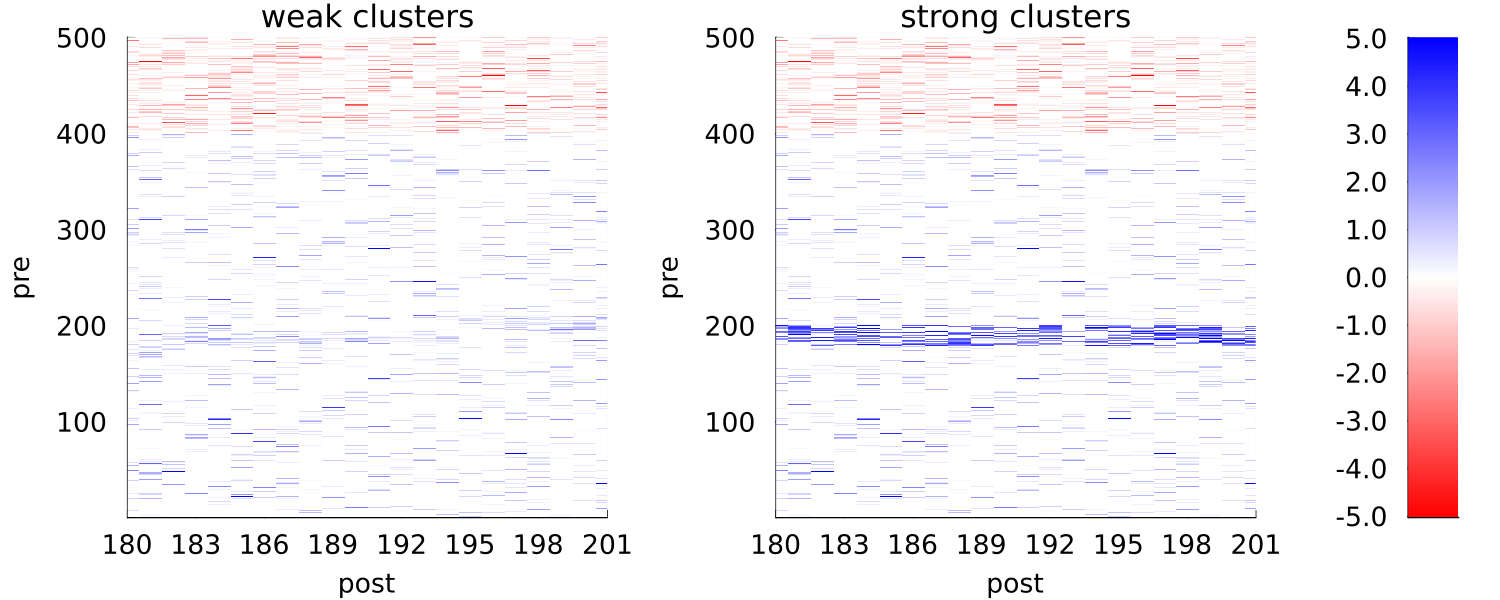

In [230]:
l = @layout [a b c{0.05w}]
maxval=maximum(Matrix(netw)[anyrange,anyrange])
ps = [heatmap(Matrix(weaknetw),clims=(-maxval, maxval),title="weak clusters",c=cgrad([:red,:white,:blue]),xlim=[cl_pat[2][1][1],cl_pat[2][1][end]],legend=:none,xlabel="post",ylabel="pre"), 
    heatmap(Matrix(netw),c=cgrad([:red,:white,:blue]),xlim=[cl_pat[2][1][1],cl_pat[2][1][end]],clims=(-maxval, maxval),title="strong clusters",legend=:none,xlabel="post",ylabel="pre")]
plot!(ps...,heatmap((-5.:0.05:5).*ones(201,1), legend=:none, xticks=:none,c=cgrad([:red,:white,:blue]),
yticks=(1:20:201, string.(-5.:1:5.)),size=(100,500),dpi=600),layout=l,size=(1000,400),bottom_margin=5Plots.mm)
plot!()

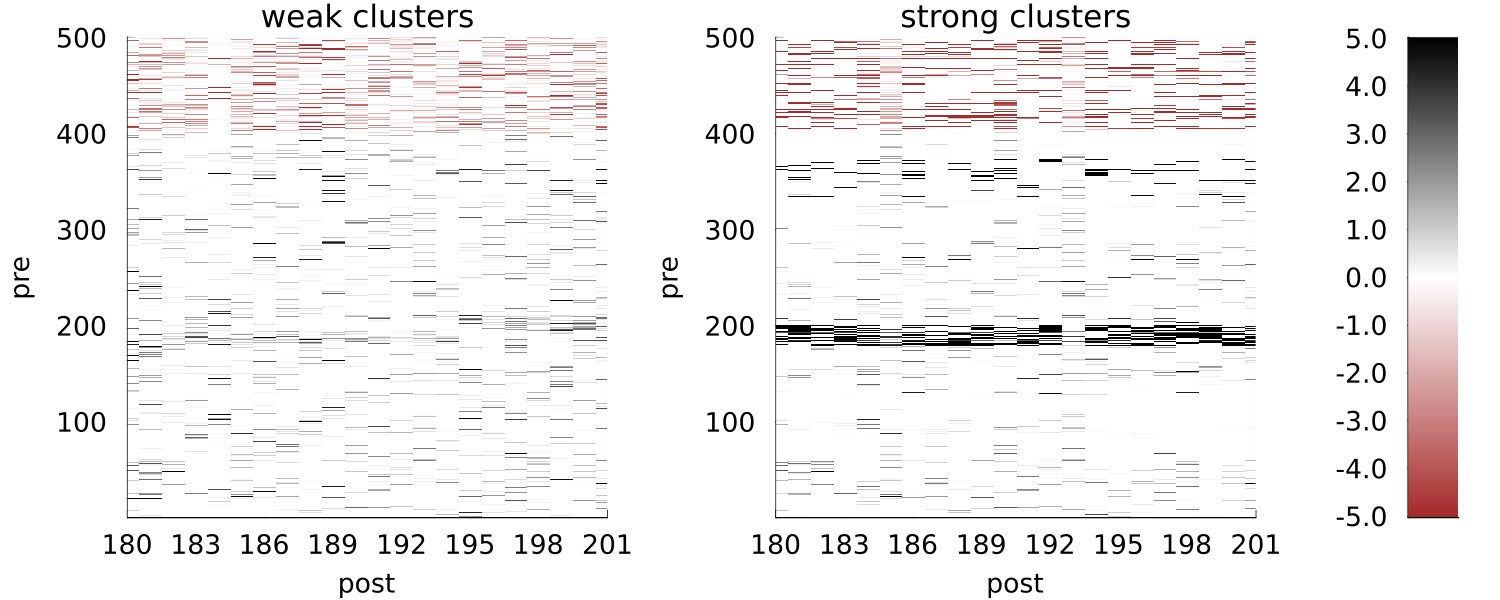

In [229]:
l = @layout [a b c{0.05w}]
maxval=maximum(Matrix(enetw)[anyrange,anyrange])
ps = [heatmap(Matrix(eweaknetw),clims=(-maxval, maxval),title="weak clusters",c=cgrad([:brown,:white,:black]),xlim=[cl_pat[2][1][1],cl_pat[2][1][end]],xlabel="post",ylabel="pre",legend=:none), 
    heatmap(Matrix(enetw),c=cgrad([:brown,:white,:black]),clims=(-maxval, maxval),xlim=[cl_pat[2][1][1],cl_pat[2][1][end]],title="strong clusters",xlabel="post",ylabel="pre",legend=:none)]
plot!(ps...,heatmap((-5.:0.05:5).*ones(201,1), legend=:none, xticks=:none,c=cgrad([:brown,:white,:black]),
yticks=(1:20:201, string.(-5.:1:5.)),size=(100,500),dpi=600),layout=l,size=(1000,400),bottom_margin=5Plots.mm)
plot!()

In [21]:
#network results

    #for eachnet in eachindex(net_clspk_pres)
    #    sums = []
    #    for (eachcl,_,_) in net_clspk_pres[eachnet]
    #        push!(sums,sum(Pi[end][:,eachcl]/Pi[1][:,eachcl]))
    #    end
    #    push!(net_strongw,sums)
    #end


net_clspk_pres = []
for pseed in ["03","04","05","06","07","08","09",10,11,12,13,14,15,16,17,18,19,20,21,22,23] 
    sim_name = "new_10sec_20"; #change this to appropriate name
    filepathname = string("../jlds/",N,"/",sim_name,pseed,".jld2");
    #to load
    @load filepathname w
    (Pi, _, csid) = w;
    #(ge, gi, gcd) = g 
end
net_weakw = []
for pseed in ["03","04","05","06","07","08","09",10,11,12,13,14,15,16,17,18,19,20,21,22,23] 
    sim_name = "new_10sec_weakcl_20"; #change this to appropriate name
    filepathname = string("../jlds/",N,"/",sim_name,pseed,".jld2");
    #to load
    @load filepathname ns v_dend v_soma gain_mod w g κ pattern #gcd poisson_in (!)
    #(inputs,pattern,pat1,pat2,pat3) = poisson_in
    (_, _, csid) = w;
    #(ge, gi, gcd) = g 
    
end

2000×1 Matrix{Float64}:
 -0.4035119213322328
  0.6772755642190043
 -0.6205061166486103
 -0.053665507428250644
  0.15682757186472762
 -1.1253207182663425
  0.19502422116933957
  0.9696301353543618
  0.17928208988434569
 -0.26636737017718404
  ⋮
  0.704785273873405
 -0.7567867605284506
  0.45386481781150756
 -0.07993511950421771
  0.8320114644639142
  0.7758169688976659
  0.45489302091995926
  0.8470293123113021
  0.2622576624237466

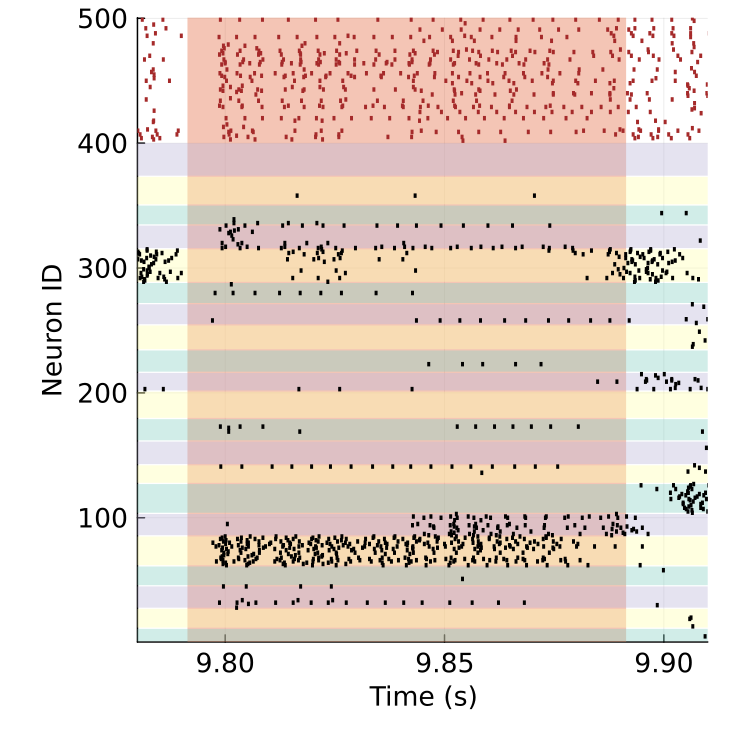

In [89]:
window = (9.78,9.91)
gr(markersize=1.5,markershape=:vline,legend=false, markercolor=:black, markerstrokewidth=2.0, markeralpha=1.0, linewidth=1.0)
h0 = plot(xlabel="Time (s)", ylabel="Neuron ID",xlim=window,ylim=(0.5,N+0.5),size=(500,500))
vspans(h0, timestamps, pattern, window,0.4)
#for clusters
cls = []
for cl in palette(:Set3_3)
    push!(cls,cl)
end
cls = repeat(cls,20)
for (i,cid) in enumerate(csid)
    hspan!(h0,[cid[1],cid[end]],fillalpha=0.4,color=cls[i],linewidth=0.0,alpha=0.0, label=nothing)
end
scatter!(h0,xs,ys, group=grouping, markercolor=[:black :brown],)
plot!(xticks=[9.80,9.85,9.90])

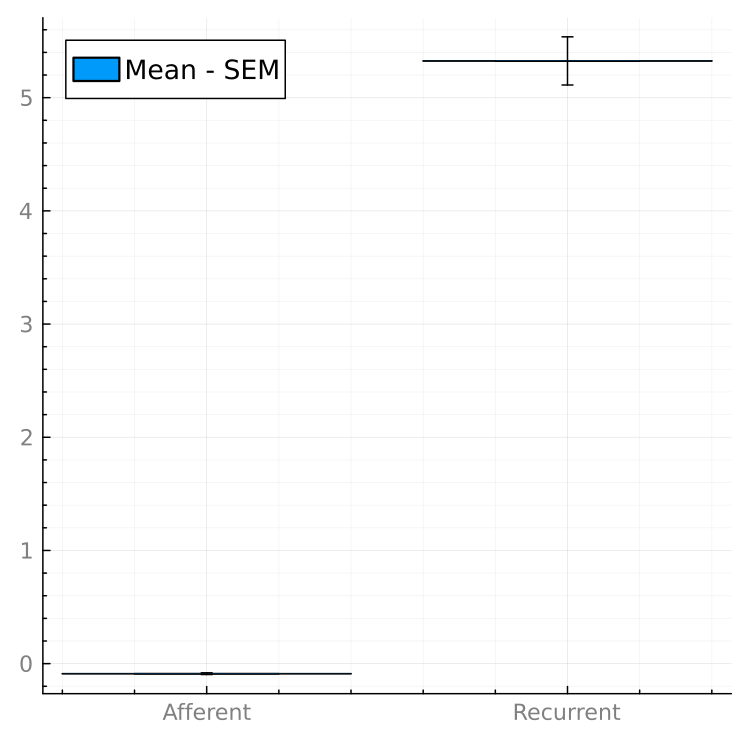

In [26]:
using StatsPlots

# Example of plasticity data (you would replace these with your actual data)
aff_data = Pi[end]# .- Pi[1]
rec_data = Pr[end]# .- Pr[1]

# Select assemblies (specific rows/columns, e.g., the first 100 rows)
aff_assemblies = aff_data[:,62:85]  # Adjust the range for your assemblies
rec_assemblies = rec_data[62:85, 62:85]

# Calculate means and SEMs for each group
mean_aff = mean(aff_assemblies)
mean_rec = mean(rec_assemblies)
sem_aff = std(aff_assemblies) / sqrt(length(aff_assemblies))
sem_rec = std(rec_assemblies) / sqrt(length(rec_assemblies))

# Plot with SEM
boxplot(["Afferent", "Recurrent"], [mean_aff, mean_rec], yerror=[sem_aff, sem_rec], label="Mean - SEM",size=(500,500))


In [28]:
length(rec_assemblies)

576

In [12]:
cl_pat[1][1]

62:85